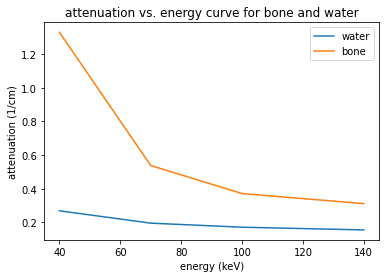

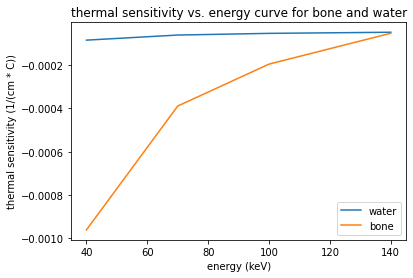

In [65]:
# DATA CALIBRATION FOR MODEL
# - attenuation vs. energy for water and bone
# - thermal sensitivity vs. energy for water and bone

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import random

# x_series: array of x values
# y_series: size n list of array of y values
# labels: size n list of labels corresponding to y_series
def line_plot(x_series, y_series, labels, title, ylabel, xlabel):
    for i in range(len(y_series)):
        plt.plot(x_series, y_series[i], label = labels[i])
        
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.legend()

# source: https://physics.nist.gov/PhysRefData/XrayMassCoef/ComTab/bone.html
df_bone = pd.read_excel('bone_attenuation_curve.xlsx')
df_water = pd.read_excel('water_attenuation_curve.xlsx')
x_bone = np.array(df_bone['energy (MeV)']) * 1000 # convert MeV to keV
y_bone = np.array(df_bone['mass attenuation (cm^2/g)'])
x_water = np.array(df_water['energy (MeV)']) * 1000
y_water = np.array(df_water['mass attenuation (cm^2/g)'])

water_attenuations = np.array([])
bone_attenuations = np.array([])

energy_levels = np.array([40, 70, 100, 140]) # in keV or kvP
num_energy_levels = energy_levels.size

# interpolate attenuations for each energy level
for i in range(num_energy_levels):
    y_bone_new = np.interp(energy_levels[i], x_bone, y_bone)
    bone_attenuations = np.append(bone_attenuations, y_bone_new)
    y_water_new = np.interp(energy_levels[i], x_water, y_water)
    water_attenuations = np.append(water_attenuations, y_water_new)
    
bone_attenuations *= 2 # convert from mass attenuation (cm^2/g) to linear attenuation (1/cm)

# attenuation vs. energy plot
line_plot(energy_levels, 
          [water_attenuations, bone_attenuations],
          ['water', 'bone'], 
          'attenuation vs. energy curve for bone and water',
          'attenuation (1/cm)',
          'energy (keV)')
plt.show()

# source: https://link.springer.com/content/pdf/10.1007/s00330-021-08206-z.pdf       
water_alphas_HU = np.array([-0.32, -0.32, -0.32, -0.32])
bone_alphas_HU = np.array([-3.58, -2, -1.15, -0.35])
water_alphas = np.array([])
bone_alphas = np.array([])

# convert thermal sensitivity from HU/C to mu/C (ie. 1/(C*cm))
for i in range(num_energy_levels):
    alpha_w = (water_alphas_HU[i]/1000) * water_attenuations[i]
    water_alphas = np.append(water_alphas, alpha_w)
    alpha_b = (bone_alphas_HU[i]/1000) * water_attenuations[i]
    bone_alphas = np.append(bone_alphas, alpha_b)

# thermal sensitivity vs. energy plot
line_plot(energy_levels, 
          [water_alphas, bone_alphas],
          ['water', 'bone'], 
          'thermal sensitivity vs. energy curve for bone and water',
          'thermal sensitivity (1/(cm * C))',
          'energy (keV)')
plt.show()

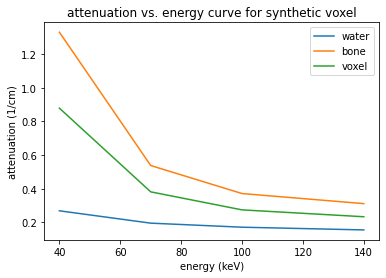

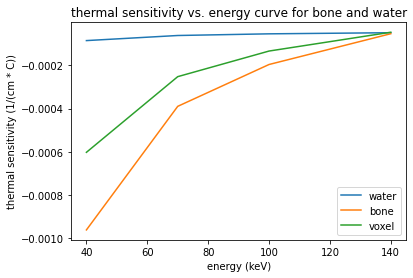

In [67]:
# GENERATE VOXEL
# - generates the attenuation and thermal sensitivity properties of a voxel
# - mu_voxel = V_w * mu_water + V_b * mu_bone                                      
# - alpha_voxel = V_w * alpha_w  + V_b * alpha_b where alpha has units of HU/C or 1/(C*cm) 

def generate_voxel(volume_fractions): 
    voxel_attenuations = np.array([])
    voxel_alphas = np.array([])
    
    # water and bone attenuations and alphas are global data
    for i in range(num_energy_levels):
        mu = volume_fractions[0] * water_attenuations[i] + volume_fractions[1] * bone_attenuations[i] # exact physical law
        voxel_attenuations = np.append(voxel_attenuations, mu)
        alpha_wb = volume_fractions[0] * water_alphas[i] + volume_fractions[1] * bone_alphas[i] # model assumption
        voxel_alphas = np.append(voxel_alphas, alpha_wb)
                                       
    return voxel_attenuations, voxel_alphas

volume_fractions = np.array([0.3, 0.6, 0.1]) # idx0: V_w, idx1: V_b, idx2: V_a
voxel_attenuations, voxel_alphas = generate_voxel(volume_fractions)
                                       
# attenuation vs. energy of voxel
line_plot(energy_levels, 
          [water_attenuations, bone_attenuations, voxel_attenuations],
          ['water', 'bone', 'voxel'], 
          'attenuation vs. energy curve for synthetic voxel',
          'attenuation (1/cm)',
          'energy (keV)')
plt.show()
    
# thermal sensitivity vs. energy of voxel
line_plot(energy_levels, 
          [water_alphas, bone_alphas, voxel_alphas],
          ['water', 'bone', 'voxel'], 
          'thermal sensitivity vs. energy curve for bone and water',
          'thermal sensitivity (1/(cm * C))',
          'energy (keV)')
plt.show()

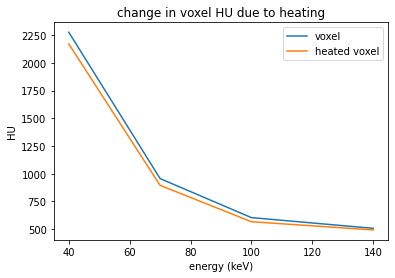

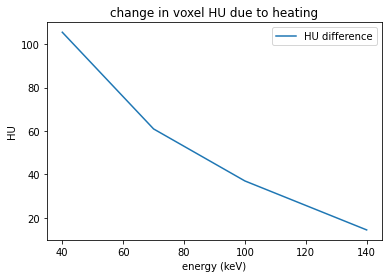

In [87]:
# HEAT VOXEL
# - decrease attenuation by alpha(E) times the change in temperature in each energy bin

# gt_temp: heated temperature
# voxel_attenuations and voxel_alphas: obtained from generate_voxel()
# t0_temp = 23: default reference temperature
def heat_voxel(gt_temp, voxel_attenuations, voxel_alphas, t0_temp=23): 
    heated_voxel_attenuations = np.copy(voxel_attenuations)
    
    for i in range(num_energy_levels):
        heated_voxel_attenuations[i] += (gt_temp - t0_temp) * voxel_alphas[i]
    
    return heated_voxel_attenuations

# convert from linear attenuation to HU
def mu_to_HU(attenuations):
    return ((attenuations - water_attenuations) / water_attenuations) * 1000

gt_temp = 70
heated_voxel_attenuations = heat_voxel(gt_temp, voxel_attenuations, voxel_alphas)

voxel_HU = mu_to_HU(voxel_attenuations)
heated_voxel_HU = mu_to_HU(heated_voxel_attenuations)
delta_HU = voxel_HU - heated_voxel_HU

line_plot(energy_levels, 
          [voxel_HU, heated_voxel_HU],
          ['voxel', 'heated voxel'], 
          'change in voxel HU due to heating',
          'HU',
          'energy (keV)')
plt.show()

line_plot(energy_levels, 
          [delta_HU],
          ['HU difference'], 
          'change in voxel HU due to heating',
          'HU',
          'energy (keV)')
plt.show()

In [95]:
# METHOD 1: TWO STEP ALGORITHM
# - computes material decomposition and predicts temperature separately
# - does not account for thermal error in material decomposition

# voxel_attenuations: obtained from generate_voxel()
# heated_voxel_attenuations: obtained from heat_voxel()
# error_level: standard deviation of Gaussian noise in HU
def two_step_algorithm(heated_voxel_attenuations, voxel_attenuations, error_level):
    col_1 = np.expand_dims(water_attenuations, axis=1)
    col_2 = np.expand_dims(bone_attenuations, axis=1)
    col_3 = np.expand_dims(np.zeros(4), axis=1)
    row_5 = np.expand_dims(np.ones(3), axis=0)
    
    # coefficient mtx is 5 by 3
    coefficient_mtx = np.append(col_1, col_2, axis=1)
    coefficient_mtx = np.append(coefficient_mtx, col_3, axis=1)
    coefficient_mtx = np.append(coefficient_mtx, row_5, axis=0)
    
    # conditions vector is 5 by 1
    conditions = np.expand_dims(np.append(heated_voxel_attenuations, 1), axis=1)
    
    # inverse matrix is 3 by 5
    inverse = np.linalg.pinv(coefficient_mtx)

    uncorrected_volume_fractions = np.matmul(inverse, conditions)
    volume_fraction_errors = uncorrected_volume_fractions.flatten() - volume_fractions
    
    voxel_HU = mu_to_HU(voxel_attenuations)
    heated_voxel_HU = mu_to_HU(heated_voxel_attenuations)
    delta_HU = voxel_HU - heated_voxel_HU
    
    # add normally distributed HU noise
    noisy_delta_HU = delta_HU + np.random.normal(0, error_level)
    pred_temp_arr = np.array([])
    
    # temperature prediction made in the HU domain
    for i in range(num_energy_levels):
        # compute HU/C thermal sensitivity
        alpha_wb = uncorrected_volume_fractions[0] * water_alphas_HU[i] + uncorrected_volume_fractions[1] * bone_alphas_HU[i] 
        pred_temp_arr = np.append(pred_temp_arr, -1 * noisy_delta_HU[i]/alpha_wb + 23)
    
    avg_temp_pred = np.mean(pred_temp_arr)
    mae_volume_fraction = np.mean(np.absolute(volume_fraction_errors)) * 100
    
    return avg_temp_pred, mae_volume_fraction

val1, val2 = two_step_algorithm(heated_voxel_attenuations, voxel_attenuations, 10)

print(val1)
print(val2)

75.78767337033187
1.7333541589932362


In [64]:
# METHOD 2: ONE STEP ALGORITHM
# convert to HU domain

def one_step_algorithm(heated_voxel_attenuations, error_level):
    heated_voxel_HU = mu_to_HU(heated_voxel_attenuations)
    noisy_heated_voxel = heated_voxel_HU + np.random.normal(0, error_level)
    water_HU = mu_to_HU(water_attenuations)
    bone_HU = mu_to_HU(bone_attenuations)
    
    col_1 = np.expand_dims(water_HU, axis=1)
    col_2 = np.expand_dims(bone_HU, axis=1)
    col_3 = np.expand_dims(np.zeros(4), axis=1)
    col_4 = np.expand_dims(water_alphas_HU, axis=1)
    col_5 = np.expand_dims(bone_alphas_HU, axis=1)

    row_5 = np.expand_dims(np.array([1, 1, 1, 0, 0]), axis=0)

    coefficient_mtx = np.append(col_1, col_2, axis=1)
    coefficient_mtx = np.append(coefficient_mtx, col_3, axis=1)
    coefficient_mtx = np.append(coefficient_mtx, col_4, axis=1)
    coefficient_mtx = np.append(coefficient_mtx, col_5, axis=1)
    coefficient_mtx = np.append(coefficient_mtx, row_5, axis=0)
    print(coefficient_mtx.shape)

    conditions = np.expand_dims(np.append(heated_voxel_HU, 1), axis=1)
    print(conditions.shape)
    inverse = np.linalg.pinv(coefficient_mtx)
    print(inverse.shape)

    output = np.matmul(inverse, conditions)

    print(output[4]/output[1] + 23)
    print(output[3]/output[0] + 23)
    
    return output
    
output = one_step_algorithm(heated_voxel_attenuations, error_level=0)

print(output)

(5, 5)
(5, 1)
(5, 5)
[90.]
[4324.20487588]
[[4.24635433e-01]
 [1.50729134e-01]
 [4.24635433e-01]
 [1.82644399e+03]
 [1.00988520e+01]]


In [98]:
# GENERATE STATISTICS
# global: water_attenuations, bone_attenuations, water_alphas_HU, bone_alphas_HU, water_alphas, bone_alphas

# def generate_voxel(volume_fractions):
# returns: voxel_attenuations, voxel_alphas

# def heat_voxel(gt_temp, voxel_attenuations, voxel_alphas):
# returns: heated_voxel_attenuations
# global: voxel_HU, heated_voxel_HU, delta_HU

# def two_step_algorithm(heated_voxel_attenuations_error_level):
# returns: np.mean(pred_temp_arr), volume_fraction_errors

error_levels = np.arange(0, 31, 1) # std. dev. of HU error

for error_level in error_levels:
    # col_1: ground truth temperature, col_2: average predicted temperature, col_3: stdev of predicted temperature
    # col_4: MAE of temperature col_5: MAE vol_frac_error
    data_file = np.empty((0, 5)) 
    
    temps = np.arange(23, 91, 1) # temperature of synthetic voxel
    
    for temp in temps:
        samples = 100 # number of random voxels to generate
        
        pred_temp_arr = np.array([])
        vol_frac_err_arr = np.array([])
        
        for i in range(samples):
            volume_fractions = np.array([]) # idx0: V_w, idx1: V_b, idx2: V_a
            
            # randomly generate volume fractions from uniform distribution
            for i in range(3):
                volume_fractions = np.append(volume_fractions, random()) # range: [0, 1)

            volume_fractions /= np.sum(volume_fractions) # normalize
            
            voxel_attenuations, voxel_alphas = generate_voxel(volume_fractions)
            heated_voxel_attenuations = heat_voxel(temp, voxel_attenuations, voxel_alphas)

            pred_temp, vol_frac_error = two_step_algorithm(heated_voxel_attenuations, voxel_attenuations, error_level)
            pred_temp_arr = np.append(pred_temp_arr, pred_temp)
            vol_frac_err_arr = np.append(vol_frac_err_arr, vol_frac_error)
            
        # temp loop
        avg_pred_temp = np.mean(pred_temp_arr)
        stdev_pred_temp = np.std(pred_temp_arr) 
        MAE_temp = np.mean(np.absolute(pred_temp_arr - temp))
        MAE_vol_frac = np.mean(vol_frac_err_arr)
        
        data_row = np.expand_dims(np.array([temp, avg_pred_temp, stdev_pred_temp, MAE_temp, MAE_vol_frac]), axis=0)
        data_file = np.append(data_row, data_file, axis = 0)  
    
    # error loop
    data_file
    df = pd.DataFrame(data_file)
    path = r'C:\Users\Nathan\Deep Learning\ct-thermometry\simulation_data\two_step_algorithm\error_level_' + str(error_level) + '.xlsx'
    df.to_excel(excel_writer = path)

# outside loops

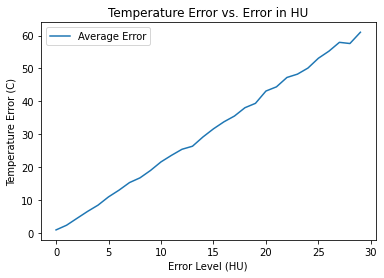

In [106]:
# VISUALIZATIONS

error_level_x = np.arange(0, 30, 1)
mae_temp_y = np.array([])

for i in range(30):
    path = r'simulation_data\two_step_algorithm\error_level_' + str(i) + '.xlsx'
    df = pd.read_excel(path)
    df = df.drop('Unnamed: 0', axis=1)

    actual_temp = df[0]
    pred_temp = df[1]
    stdev_pred_temp = df[2]
    mae_temp = df[3]
    mae_temp_y = np.append(mae_temp_y, np.mean(mae_temp))
    mae_vol_frac = df[4]

# avg. mae temp error vs. error_level
line_plot(error_level_x, 
          [mae_temp_y],
          ['Average Error'], 
          'Temperature Error vs. Error in HU',
          'Temperature Error (C)',
          'Error Level (HU)')
plt.show()

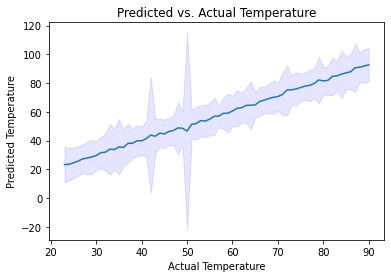

In [114]:
i=2
path = r'simulation_data\two_step_algorithm\error_level_' + str(i) + '.xlsx'
df = pd.read_excel(path)
df = df.drop('Unnamed: 0', axis=1)

actual_temp = df[0]
pred_temp = df[1]
stdev_pred_temp = df[2]
mae_temp = df[3]
mae_vol_frac = df[4]

ci = 1.96 * stdev_pred_temp

plt.plot(actual_temp, pred_temp)

plt.title('Predicted vs. Actual Temperature')
plt.ylabel('Predicted Temperature')
plt.xlabel('Actual Temperature')

plt.fill_between(actual_temp, (pred_temp-ci), (pred_temp+ci), color='b', alpha=.1)

plt.show()